In [1]:
'''
This NB explores the use of MTL RNN in forecasting
PH export activity

'''

'\nThis NB explores the use of MTL RNN in forecasting\nPH export activity\n\n'

In [2]:
# Standard imports from TS Class
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from prophet import Prophet
import os

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)


In [3]:
if not(os.path.exists('./data/SPGlobal_Exports_clean.csv')):
    DAT_Export = pd.read_excel('./data/SPGlobal_Exports.xls', skiprows=4)
    DAT_Export.dropna(axis=0, thresh=120, inplace=True)
    DAT_Export = DAT_Export.T.iloc[1:,:]
    DAT_Export.columns = DAT_Export.iloc[0,:].values

    DAT_Export = DAT_Export.iloc[1:,:]
    DAT_Export.reset_index(inplace=True)
    DAT_Export

    #create date series
    DAT_Export['ds'] = pd.date_range(start='1/1/2010', periods=DAT_Export.shape[0], freq='MS').sort_values(ascending=False)
    DAT_Export.drop(columns=['index'], inplace=True)
    DAT_Export.sort_values(by='ds',ascending=True).to_csv('./data/SPGlobal_Exports_clean.csv', index=False)

DAT_Export = pd.read_csv('./data/SPGlobal_Exports_clean.csv')
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)
DAT_Export

,ds,unique_id,y
0,2010-01-01,AUS,618.538
1,2010-02-01,AUS,613.971
2,2010-03-01,AUS,699.770
3,2010-04-01,AUS,769.386
4,2010-05-01,AUS,829.484
...,...,...,...
3289,2024-11-01,VNM,1886.123
3290,2024-12-01,VNM,1981.849
3291,2025-01-01,VNM,1843.337
3292,2025-02-01,VNM,1717.466


In [60]:
#Setup TRAIN - VAL - TEST
temp = DAT_Export.pivot(index='ds', columns='unique_id', values='y').reset_index()
temp.set_index('ds', inplace=True, drop=True)
temp[temp.index < '2024-01-01'].to_csv('TRAIN.csv', index=True)
temp[temp.index >= '2024-01-01'].to_csv('TEST.csv', index=True)


<Axes: xlabel='ds'>

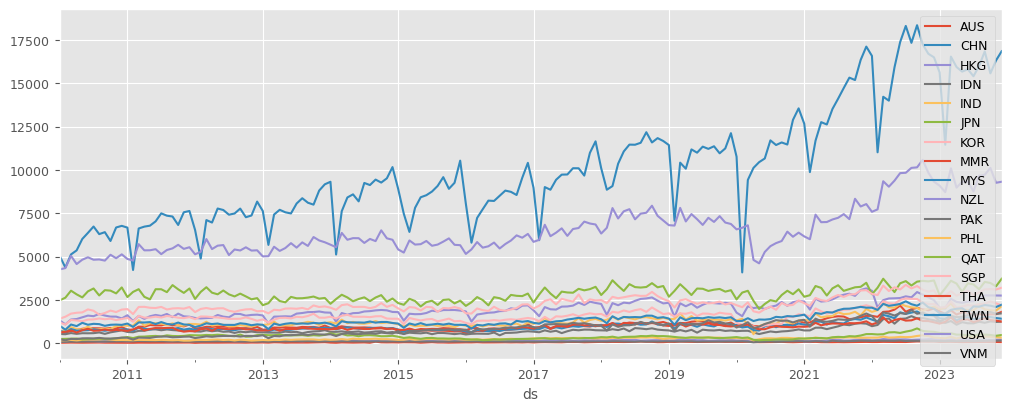

In [61]:
TRAIN = pd.read_csv('TRAIN.csv', index_col = 0, parse_dates=True)
TEST = pd.read_csv('TEST.csv', index_col = 0, parse_dates=True)

TRAIN.plot()

/var/folders/9y/vgkg6w9144v1vtff9_5ft2fw0000gn/T/ipykernel_3693/2464336589.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


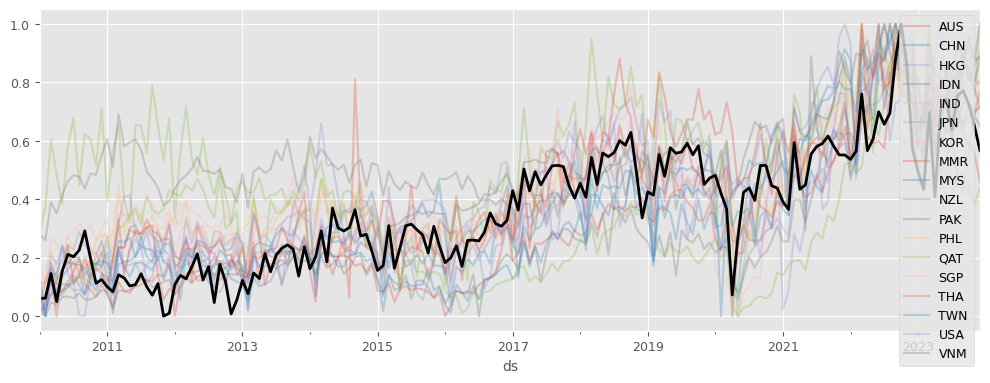

In [63]:
# pre-processing

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
TRAINz = TRAIN.copy()
temp = pd.DataFrame(scaler.fit_transform(TRAIN),
                      index = TRAIN.index, 
                      columns=TRAIN.columns)
TRAINz.update(temp)
TRAINz.plot(alpha = 0.3)
TRAINz['PHL'].plot(color='k', linewidth=2)
plt.tight_layout()

In [ ]:
# SETUP DATA and LOOKBACK WINDOW
DIR = './' #using local

def preprocess_data(LOOKBACK, HORIZON, VARS):
    ''' Preprocess_data function takes the
    horizon value and regressors for the model

    parameters
    ----------
    HORIZON: int - horizon to forecast
    VARS: list - list of variables as regressors
        [price, *additional regressors]

    returns
    -------
    tuple: (HORIZON, X_train, X_test, scaler)

    '''

    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    #prepare train dataset

    TRAIN = pd.read_csv(f'{DIR}TRAIN.csv', index_col = 0)[VARS]

    scaler = MinMaxScaler(feature_range = (0,1))
    trainz = pd.DataFrame(scaler.fit_transform(TRAIN),
                          columns = TRAIN.columns, index = TRAIN.index)


    #create input-output pair sequence
    X_train = []
    y_train = []
    trainz_arr = trainz.to_numpy()
    for i in range(LOOKBACK,len(TRAIN) - HORIZON):
        #considering time i
        #will take values of x[i-LOOKBACK, ..., i]
        #train it with values of y[i + HORIZON]
        X_train.append(trainz_arr[i - LOOKBACK:i,:])

        #consider replacing to multi-step horizon
        #given past 60 unit, what is the value of y[i + HORIZON] (one-point)

        y_train.append(trainz_arr[i + HORIZON,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    #print(HORIZON, LOOKBACK, TRAIN.shape, X_train.shape, i)
    if len(X_train.shape) == 2:
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


    #prepare test dataset
    TEST = pd.read_csv(f'{DIR}TEST.csv', index_col = 0)[VARS]

    dataset_total = pd.concat([TRAIN, TEST],axis=0)
    dataset_total.index = pd.to_datetime(dataset_total.index)

    inputs = dataset_total[len(dataset_total) - len(TEST) - LOOKBACK:].values
    if len(X_train.shape) == 2:
        inputs = inputs.reshape(-1, 1)

    # Apply the same scaling used for training data
    inputs = scaler.transform(inputs)

    # Prepare the test input sequences
    # (same 60-timestep structure as training data)
    X_test = []
    for i in range(LOOKBACK, len(inputs)-HORIZON):  # 311 = 60 + len(test_set)
        # For each step, take the previous 60 time steps as input
        X_test.append(inputs[i-LOOKBACK:i, :])


    # Convert the list to a NumPy array
    X_test = np.array(X_test)

    #print(HORIZON, X_test.shape, len(TEST)-HORIZON)
    #print(X_test)
    # Reshape to 3D format: [samples, timesteps, features] as required by LSTM
    if len(X_test.shape) == 2:
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #print(X_test.shape, len(TEST))

    return (HORIZON, X_train, y_train, X_test, scaler)



In [71]:
VARS = TRAIN.columns.tolist()
HORIZON = 3
LOOKBACK = 12
out = preprocess_data(LOOKBACK, HORIZON, VARS)
out[1].shape

/Users/mlgcastanares/opt/anaconda3/envs/BankSentiment/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(153, 12, 18)

In [33]:
import torch
from torch import nn


class FFNN(nn.Module):
    """Simple FF network with multiple outputs.
    """
    def __init__(
        self,
        input_size,
        hidden_size,
        n_hidden,
        n_outputs,
        dropout_rate=.1,
    ):
        """

        :param input_size: input size
        :param hidden_size: common hidden size for all layers
        :param n_hidden: number of hidden layers
        :param n_outputs: number of outputs
        :param dropout_rate: dropout rate
        """
        super().__init__()
        assert 0 <= dropout_rate < 1
        self.input_size = input_size

        h_sizes = [self.input_size] + [hidden_size for _ in range(n_hidden)] + [n_outputs]

        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes) - 1):
            self.hidden.append(
                nn.Linear(
                    h_sizes[k],
                    h_sizes[k + 1]
                )
            )

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):

        for layer in self.hidden[:-1]:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)

        return self.hidden[-1](x)

class TaskIndependentLayers(nn.Module):
    """NN for MTL with hard parameter sharing
    """

    def __init__(
            self,
            input_size,
            hidden_size,
            n_hidden,
            n_outputs,
            dropout_rate=.1,
    ):

        super().__init__()
        self.n_outputs = n_outputs
        self.task_nets = nn.ModuleList()
        for _ in range(n_outputs):
            self.task_nets.append(
                FFNN(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    n_hidden=n_hidden,
                    n_outputs=1,
                    dropout_rate=dropout_rate,
                )
            )

    def forward(self, x):

        return torch.cat(
            tuple(task_model(x) for task_model in self.task_nets),
            dim=1
        )

class HardSharing(nn.Module):
    """FFNN with hard parameter sharing
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        n_hidden,
        n_outputs,
        n_task_specific_layers=0,
        task_specific_hidden_size=None,
        dropout_rate=.1,
    ):

        super().__init__()
        if task_specific_hidden_size is None:
            task_specific_hidden_size = hidden_size

        self.model = nn.Sequential()

        self.model.add_module(
            'hard_sharing',
            FFNN(
                input_size=input_size,
                hidden_size=hidden_size,
                n_hidden=n_hidden,
                n_outputs=hidden_size,
                dropout_rate=dropout_rate
            )
        )

        if n_task_specific_layers > 0:
            # if n_task_specific_layers == 0 than the task specific mapping is linear and
            # constructed as the product of last layer is the 'hard_sharing' and the linear layer
            # in 'task_specific', with no activation or dropout
            self.model.add_module('relu', nn.ReLU())
            self.model.add_module('dropout', nn.Dropout(p=dropout_rate))

        self.model.add_module(
            'task_specific',
            TaskIndependentLayers(
                input_size=hidden_size,
                hidden_size=task_specific_hidden_size,
                n_hidden=n_task_specific_layers,
                n_outputs=n_outputs,
                dropout_rate=dropout_rate
            )
        )

    def forward(self, x):
        return self.model(x)

In [268]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

class MTLRNNHardSharing(nn.Module):
    """RNN with hard parameter sharing for multi-task learning"""
    
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 num_layers, 
                 n_tasks,
                 dropout_rate=0.1,
                 rnn_type='LSTM'):
        super(MTLRNNHardSharing, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.n_tasks = n_tasks
        self.rnn_type = rnn_type
        
        # Key: Shared RNN layers
        # There is ONE single RNN (LSTM or GRU) that processes all tasks. 
        # All countries share the exact same RNN parameters 
        # - this is the "hard" sharing.
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, 
                              batch_first=True, dropout=dropout_rate)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers,
                             batch_first=True, dropout=dropout_rate)
        
        # Key: Task-specific output layers
        # Each country gets its own separate output head
        # but they all receive the same shared RNN features.
        # This section collects the results from the shared 
        # hidden layer and applies to task-specific output layer
        self.task_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_size // 2, 1)
            ) for _ in range(n_tasks)
        ])
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        
        # Shared RNN processing
        if self.rnn_type == 'LSTM':
            rnn_out, (hidden, cell) = self.rnn(x)
        else:
            rnn_out, hidden = self.rnn(x)
        
        # Use last time step output
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Task-specific predictions
        task_outputs = []
        for task_head in self.task_heads:
            task_output = task_head(last_output)
            task_outputs.append(task_output)
        
        return torch.cat(task_outputs, dim=1)  # (batch_size, n_tasks)

def create_sequences_multi_task(data, lookback, countries):
    """Create sequences for multi-task learning"""
    X, y = [], []
    
    for i in range(lookback, len(data)):
        # Input sequence (all countries for context)
        X.append(data[i-lookback:i].values)
        
        # Output (target countries only)
        y.append(data.iloc[i][countries].values)
    
    return np.array(X), np.array(y)

def prepare_mtl_data(lookback=12, target_countries=['PHL', 'CHN', 'USA', 'JPN']):
    """Prepare data for multi-task learning"""
    
    # Load and preprocess data
    TRAIN = pd.read_csv('./TRAIN.csv', index_col=0, parse_dates=True)
    TEST = pd.read_csv('./TEST.csv', index_col=0, parse_dates=True)
    
    # Scale data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    
    # Fit scaler on training data
    train_scaled = pd.DataFrame(
        scaler.fit_transform(TRAIN),
        index=TRAIN.index,
        columns=TRAIN.columns
    )
    
    # Transform test data
    test_scaled = pd.DataFrame(
        scaler.transform(TEST),
        index=TEST.index,
        columns=TEST.columns
    )
    
    # Create sequences
    X_train, y_train = create_sequences_multi_task(train_scaled, lookback, target_countries)
    
    # For test data, we need to include some training data for the lookback
    combined_data = pd.concat([train_scaled.tail(lookback), test_scaled])
    X_test, y_test = create_sequences_multi_task(combined_data, lookback, target_countries)
    
    return X_train, y_train, X_test, y_test, scaler, target_countries

def train_mtl_model(model, train_loader, val_loader, epochs=500, lr=0.01):
    """Train the multi-task learning model"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_mtl_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    return train_losses, val_losses

def evaluate_model(model, test_loader, scaler, target_countries):
    """Evaluate the model and compute metrics"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            
            predictions.append(outputs.cpu().numpy())
            actuals.append(batch_y.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Inverse transform predictions and actuals
    # Create dummy arrays for inverse transform
    dummy_pred = np.zeros((predictions.shape[0], len(scaler.feature_names_in_)))
    dummy_actual = np.zeros((actuals.shape[0], len(scaler.feature_names_in_)))
    
    for i, country in enumerate(target_countries):
        country_idx = list(scaler.feature_names_in_).index(country)
        dummy_pred[:, country_idx] = predictions[:, i]
        dummy_actual[:, country_idx] = actuals[:, i]
    
    # Inverse transform
    pred_inv = scaler.inverse_transform(dummy_pred)
    actual_inv = scaler.inverse_transform(dummy_actual)
    
    # Calculate metrics for each country
    metrics = {}
    for i, country in enumerate(target_countries):
        country_idx = list(scaler.feature_names_in_).index(country)
        pred_country = pred_inv[:, country_idx]
        actual_country = actual_inv[:, country_idx]
        
        mse = mean_squared_error(actual_country, pred_country)
        mae = mean_absolute_error(actual_country, pred_country)
        rmse = np.sqrt(mse)
        
        metrics[country] = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse
        }
    
    return predictions, actuals, metrics

def collect_evalmetrics():
    '''The function collects the predictions
    and calculates evaluation metrics
    '''

    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.tsa.stattools import acf

    #Check residuals
    residuals = actuals - predictions
    df_res = pd.DataFrame(residuals,
                        index = TEST.index,
                        columns = target_countries)

    collect = {}
    collect['N_EXTRA_TASKS'] = len(target_countries) - 1
    collect['TASK'] = '_'.join(target_countries)
    collect['TRAIN_LOSS'] = train_losses[-1]
    collect['VAL_LOSS'] = val_losses[-1]
    collect['TRAIN_MAE'] = metrics_train['PHL']['MAE']
    collect['TEST_MAE'] = metrics['PHL']['MAE']
    collect['TEST_bias'] = df_res.describe().loc['mean','PHL']
    collect['TEST_ACORR_LB'] = acorr_ljungbox(df_res["PHL"], boxpierce=True, period = 10)

    collect['TEST_eacf'] = acf(df_res['PHL'], nlags=1)[-1]
    collect['TEST_eacf10'] = np.sum(acf(df_res['PHL'], nlags=10)**2)

    collect['df_res'] = df_res

    return collect


In [264]:
countries = [x for x in TEST.columns.tolist() if x != 'PHL']


extra_tasks = []
i = 0
while len(extra_tasks) < 20:
    temp = sorted(np.random.choice(countries,
                             size = np.random.randint(4, len(countries) + 1),
                             replace=False))
    tag = '_'.join(temp)
    if tag not in extra_tasks:
        extra_tasks.append(tag)
        i += 1

for extra_task in extra_tasks:
    print(['PHL'] +extra_task.split('_'))

['PHL', 'AUS', 'CHN', 'HKG', 'IDN', 'IND', 'JPN', 'KOR', 'MMR', 'MYS', 'NZL', 'PAK', 'QAT', 'SGP', 'THA', 'TWN', 'USA', 'VNM']
['PHL', 'AUS', 'CHN', 'HKG', 'IDN', 'IND', 'JPN', 'KOR', 'MMR', 'MYS', 'NZL', 'PAK', 'QAT', 'SGP', 'TWN', 'USA', 'VNM']
['PHL', 'AUS', 'CHN', 'IDN', 'JPN', 'KOR', 'MMR', 'NZL', 'QAT', 'SGP', 'TWN', 'USA', 'VNM']
['PHL', 'AUS', 'CHN', 'HKG', 'IDN', 'QAT', 'SGP', 'THA', 'VNM']
['PHL', 'AUS', 'CHN', 'HKG', 'IDN', 'IND', 'JPN', 'MMR', 'MYS', 'NZL', 'PAK', 'QAT', 'SGP', 'THA', 'TWN', 'USA', 'VNM']
['PHL', 'AUS', 'CHN', 'HKG', 'IDN', 'IND', 'KOR', 'MMR', 'MYS', 'NZL', 'QAT', 'TWN', 'USA', 'VNM']
['PHL', 'CHN', 'IDN', 'IND', 'JPN', 'MMR', 'MYS', 'PAK', 'SGP', 'THA', 'TWN', 'VNM']
['PHL', 'CHN', 'IDN', 'IND', 'JPN', 'KOR', 'MYS', 'NZL', 'PAK', 'QAT']
['PHL', 'AUS', 'CHN', 'HKG', 'IDN', 'IND', 'JPN', 'MMR', 'NZL', 'PAK', 'QAT', 'SGP', 'THA', 'TWN', 'USA', 'VNM']
['PHL', 'JPN', 'MMR', 'PAK', 'QAT']
['PHL', 'IDN', 'JPN', 'MMR', 'QAT', 'THA', 'TWN', 'VNM']
['PHL', 'AUS', '

In [272]:
from IPython.display import clear_output
import time

# Main training execution
lookback = 12
countries = [x for x in TEST.columns.tolist() if x != 'PHL']

start = time.time()
results = []
for extra_task in extra_tasks:
    # Prepare data
    target_countries = ['PHL'] + extra_task.split('_')
    

    X_train, y_train, X_test, y_test, scaler, countries = prepare_mtl_data(
        lookback=lookback, 
        target_countries=target_countries
    )
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")
    print(f"Target countries: {countries}")
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test) #(obs x n_tasks)
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Split training data for validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize model
    input_size = X_train.shape[2]  # Number of features
    hidden_size = 64
    num_layers = 2
    n_tasks = len(target_countries)
    
    model = MTLRNNHardSharing(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        n_tasks=n_tasks,
        dropout_rate=0.1,
        rnn_type='LSTM'
    )
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    train_losses, val_losses = train_mtl_model(
        model, train_loader, val_loader, 
        epochs=200, lr=0.001
    )
    
    # Load best model
    model.load_state_dict(torch.load('best_mtl_model.pth'))
    
    # Evaluate model
    predictions, actuals, metrics = evaluate_model(
        model, test_loader, scaler, target_countries
    )

    fit, train_obs, metrics_train = evaluate_model(
        model, train_loader, scaler, target_countries
    )
    
    # Print metrics
    print("\nModel Performance:")
    print("-" * 50)
    for country, metric in metrics.items():
        print(f"{country}:")
        print(f"  RMSE: {metric['RMSE']:.4f}")
        print(f"  MAE:  {metric['MAE']:.4f}")
        print(f"  MSE:  {metric['MSE']:.4f}")
        print()
    
    results.append(collect_evalmetrics())

    clear_output()

print(f"Total runtime: {time.time() - start:.2f} seconds")

Total runtime: 193.66 seconds


In [273]:
res = pd.DataFrame.from_records(results).drop(columns=['TEST_ACORR_LB', 'df_res']).sort_values(by='TEST_MAE')
res.to_csv('MTL_LSTM_HPS_results.csv', index=False)
res

,N_EXTRA_TASKS,TASK,TRAIN_LOSS,VAL_LOSS,TRAIN_MAE,TEST_MAE,TEST_bias,TEST_eacf,TEST_eacf10
1,16,PHL_AUS_CHN_HKG_IDN_IND_JPN_KOR_MMR_MYS_NZL_PA...,0.009,0.010,21.080,13.784,-0.017,0.083,1.269
10,7,PHL_IDN_JPN_MMR_QAT_THA_TWN_VNM,0.009,0.007,20.613,14.081,0.005,0.062,1.321
14,10,PHL_AUS_HKG_IDN_IND_JPN_KOR_NZL_PAK_QAT_THA,0.009,0.010,18.908,14.124,-0.026,0.068,1.239
17,16,PHL_AUS_CHN_HKG_IDN_IND_JPN_KOR_MMR_MYS_NZL_PA...,0.008,0.009,17.694,14.608,-0.007,0.124,1.252
8,15,PHL_AUS_CHN_HKG_IDN_IND_JPN_MMR_NZL_PAK_QAT_SG...,0.008,0.011,19.855,14.651,-0.006,0.103,1.279
12,5,PHL_IND_JPN_MMR_QAT_USA,0.009,0.011,18.965,14.725,0.013,0.099,1.255
5,13,PHL_AUS_CHN_HKG_IDN_IND_KOR_MMR_MYS_NZL_QAT_TW...,0.008,0.006,20.037,14.887,-0.026,0.159,1.251
0,17,PHL_AUS_CHN_HKG_IDN_IND_JPN_KOR_MMR_MYS_NZL_PA...,0.007,0.007,17.348,14.901,-0.020,0.098,1.291
15,15,PHL_CHN_HKG_IDN_IND_JPN_KOR_MMR_MYS_NZL_PAK_SG...,0.010,0.007,19.758,14.992,0.009,0.074,1.319
13,10,PHL_AUS_IDN_IND_MMR_MYS_NZL_PAK_SGP_THA_VNM,0.009,0.007,18.988,15.063,-0.034,0.109,1.227


In [274]:
res.TASK[0]

'PHL_AUS_CHN_HKG_IDN_IND_JPN_KOR_MMR_MYS_NZL_PAK_QAT_SGP_THA_TWN_USA_VNM'

In [ ]:
from IPython.display import clear_output
import time

# Main training execution
lookback = 12
countries = [x for x in TEST.columns.tolist() if x != 'PHL']

start = time.time()

extra_task = 'PHL_AUS_CHN_HKG_IDN_IND_JPN_KOR_MMR_MYS_NZL_PAK_QAT_SGP_THA_TWN_USA_VNM'
# Prepare data
target_countries = ['PHL'] + extra_task.split('_')


X_train, y_train, X_test, y_test, scaler, countries = prepare_mtl_data(
    lookback=lookback, 
    target_countries=target_countries
)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")
print(f"Target countries: {countries}")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test) #(obs x n_tasks)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Split training data for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
n_tasks = len(target_countries)

model = MTLRNNHardSharing(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    n_tasks=n_tasks,
    dropout_rate=0.1,
    rnn_type='LSTM'
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
train_losses, val_losses = train_mtl_model(
    model, train_loader, val_loader, 
    epochs=300, lr=0.001
)

# Load best model
model.load_state_dict(torch.load('best_mtl_model.pth'))

# Evaluate model
predictions, actuals, metrics = evaluate_model(
    model, test_loader, scaler, target_countries
)

fit, train_obs, metrics_train = evaluate_model(
    model, train_loader, scaler, target_countries
)

# Print metrics
print("\nModel Performance:")
print("-" * 50)
for country, metric in metrics.items():
    print(f"{country}:")
    print(f"  RMSE: {metric['RMSE']:.4f}")
    print(f"  MAE:  {metric['MAE']:.4f}")
    print(f"  MSE:  {metric['MSE']:.4f}")
    print()

print(f"Total runtime: {time.time() - start:.2f} seconds")

Training data shape: X=(156, 12, 18), y=(156, 19)
Test data shape: X=(15, 12, 18), y=(15, 19)
Target countries: ['PHL', 'PHL', 'AUS', 'CHN', 'HKG', 'IDN', 'IND', 'JPN', 'KOR', 'MMR', 'MYS', 'NZL', 'PAK', 'QAT', 'SGP', 'THA', 'TWN', 'USA', 'VNM']
Model parameters: 94,931
Epoch [10/200], Train Loss: 0.026202, Val Loss: 0.018582
Epoch [20/200], Train Loss: 0.016930, Val Loss: 0.013511
Epoch [30/200], Train Loss: 0.014338, Val Loss: 0.011857
Epoch [40/200], Train Loss: 0.011695, Val Loss: 0.010011
Epoch [50/200], Train Loss: 0.011833, Val Loss: 0.008989
Epoch [60/200], Train Loss: 0.011393, Val Loss: 0.009080
Epoch [70/200], Train Loss: 0.010008, Val Loss: 0.008589
Epoch [80/200], Train Loss: 0.009594, Val Loss: 0.008844
Epoch [90/200], Train Loss: 0.010070, Val Loss: 0.008287
Epoch [100/200], Train Loss: 0.008960, Val Loss: 0.008103
Epoch [110/200], Train Loss: 0.008899, Val Loss: 0.008086
Epoch [120/200], Train Loss: 0.008296, Val Loss: 0.007826
Epoch [130/200], Train Loss: 0.008375, Val

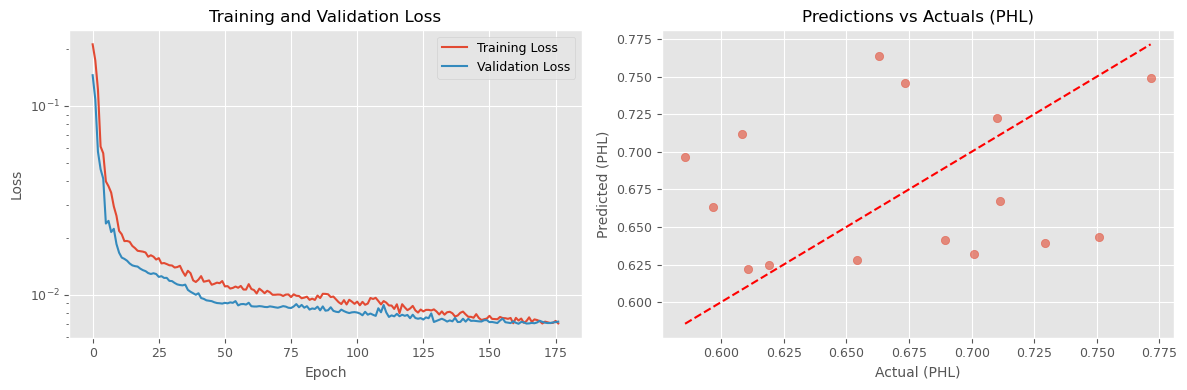

<Axes: xlabel='ds'>

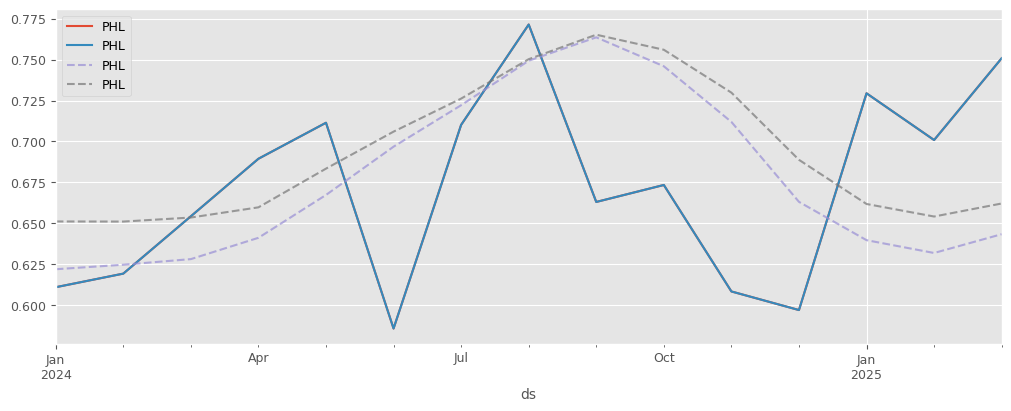

In [276]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Plot predictions vs actuals for PHL (first country)
phl_idx = 0
plt.scatter(actuals[:, phl_idx], predictions[:, phl_idx], alpha=0.6)
plt.plot([actuals[:, phl_idx].min(), actuals[:, phl_idx].max()], 
            [actuals[:, phl_idx].min(), actuals[:, phl_idx].max()], 'r--')
plt.xlabel('Actual (PHL)')
plt.ylabel('Predicted (PHL)')
plt.title('Predictions vs Actuals (PHL)')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots()

df_TEST = pd.DataFrame(actuals, columns=target_countries, index=TEST.index)
df_pred = pd.DataFrame(predictions, columns=target_countries, index=TEST.index)

df_TEST['PHL'].plot(ax=ax)
df_pred['PHL'].plot(ax=ax, linestyle='--', alpha=0.7)

In [ ]:
#collect results



ValueError: x and y must have same first dimension, but have shapes (3,) and (15,)

<Figure size 1500x1000 with 0 Axes>

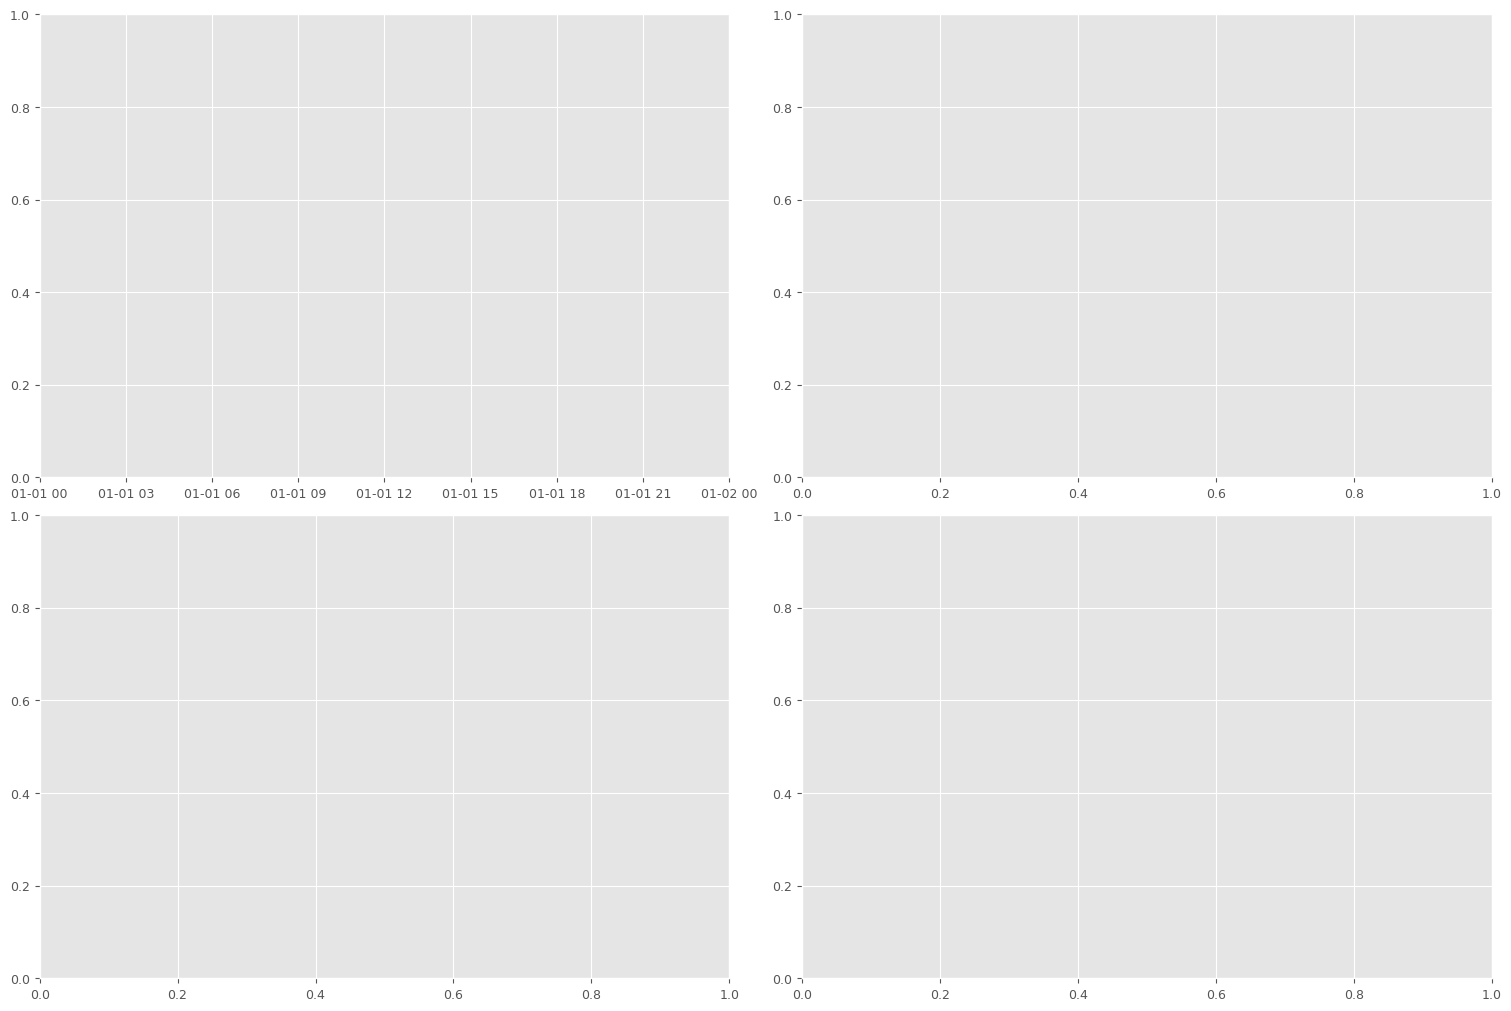

In [151]:
# Plot latest predictions with more detailed visualization
plt.figure(figsize=(15, 10))

# Get the test data dates for proper x-axis
TEST_dates = pd.read_csv('./TEST.csv', index_col=0, parse_dates=True)
test_dates = TEST_dates.index[lookback:]  # Skip initial lookback period

# Create subplots for each country
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, country in enumerate(target_countries):
    ax = axes[i]
    
    # Get country index in scaler
    country_idx = list(scaler.feature_names_in_).index(country)
    
    # Inverse transform for this country
    dummy_pred = np.zeros((predictions.shape[0], len(scaler.feature_names_in_)))
    dummy_actual = np.zeros((actuals.shape[0], len(scaler.feature_names_in_)))
    
    dummy_pred[:, country_idx] = predictions[:, i]
    dummy_actual[:, country_idx] = actuals[:, i]
    
    pred_inv = scaler.inverse_transform(dummy_pred)[:, country_idx]
    actual_inv = scaler.inverse_transform(dummy_actual)[:, country_idx]
    
    # Plot time series
    ax.plot(test_dates[:len(actual_inv)], actual_inv, 'b-', label='Actual', linewidth=2)
    ax.plot(test_dates[:len(pred_inv)], pred_inv, 'r--', label='Predicted', linewidth=2)
    
    ax.set_title(f'{country} Export Predictions')
    ax.set_xlabel('Date')
    ax.set_ylabel('Export Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add metrics as text
    rmse = metrics[country]['RMSE']
    mae = metrics[country]['MAE']
    ax.text(0.02, 0.98, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [ ]:

# Create a summary comparison plot
plt.figure(figsize=(12, 8))

# Plot 1: Prediction vs Actual scatter for all countries
plt.subplot(2, 2, 1)
colors = ['blue', 'red', 'green', 'orange']
for i, country in enumerate(target_countries):
    country_idx = list(scaler.feature_names_in_).index(country)
    
    dummy_pred = np.zeros((predictions.shape[0], len(scaler.feature_names_in_)))
    dummy_actual = np.zeros((actuals.shape[0], len(scaler.feature_names_in_)))
    
    dummy_pred[:, country_idx] = predictions[:, i]
    dummy_actual[:, country_idx] = actuals[:, i]
    
    pred_inv = scaler.inverse_transform(dummy_pred)[:, country_idx]
    actual_inv = scaler.inverse_transform(dummy_actual)[:, country_idx]
    
    plt.scatter(actual_inv, pred_inv, alpha=0.6, color=colors[i], label=country)

# Perfect prediction line
all_values = np.concatenate([pred_inv, actual_inv])
plt.plot([all_values.min(), all_values.max()], [all_values.min(), all_values.max()], 'k--', alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actuals (All Countries)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Residuals over time for PHL
plt.subplot(2, 2, 2)
phl_idx = 0
country_idx = list(scaler.feature_names_in_).index('PHL')

dummy_pred = np.zeros((predictions.shape[0], len(scaler.feature_names_in_)))
dummy_actual = np.zeros((actuals.shape[0], len(scaler.feature_names_in_)))

dummy_pred[:, country_idx] = predictions[:, phl_idx]
dummy_actual[:, country_idx] = actuals[:, phl_idx]

pred_inv = scaler.inverse_transform(dummy_pred)[:, country_idx]
actual_inv = scaler.inverse_transform(dummy_actual)[:, country_idx]

residuals = actual_inv - pred_inv
plt.plot(test_dates[:len(residuals)], residuals, 'b-', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time (PHL)')
plt.grid(True, alpha=0.3)

# Plot 3: RMSE comparison
plt.subplot(2, 2, 3)
countries = list(metrics.keys())
rmse_values = [metrics[country]['RMSE'] for country in countries]
bars = plt.bar(countries, rmse_values, color=['blue', 'red', 'green', 'orange'])
plt.ylabel('RMSE')
plt.title('RMSE Comparison by Country')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_values)*0.01,
             f'{value:.2f}', ha='center', va='bottom')

# Plot 4: Training loss curves
plt.subplot(2, 2, 4)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*60)
print("DETAILED PREDICTION RESULTS")
print("="*60)

for country in target_countries:
    print(f"\n{country} Export Predictions:")
    print("-" * 30)
    
    country_idx = list(scaler.feature_names_in_).index(country)
    task_idx = target_countries.index(country)
    
    # Get inverse transformed values
    dummy_pred = np.zeros((predictions.shape[0], len(scaler.feature_names_in_)))
    dummy_actual = np.zeros((actuals.shape[0], len(scaler.feature_names_in_)))
    
    dummy_pred[:, country_idx] = predictions[:, task_idx]
    dummy_actual[:, country_idx] = actuals[:, task_idx]
    
    pred_inv = scaler.inverse_transform(dummy_pred)[:, country_idx]
    actual_inv = scaler.inverse_transform(dummy_actual)[:, country_idx]
    
    # Show last 5 predictions
    print("Last 5 predictions:")
    for i in range(max(0, len(pred_inv)-5), len(pred_inv)):
        date = test_dates[i] if i < len(test_dates) else "N/A"
        print(f"  {date}: Actual={actual_inv[i]:.2f}, Predicted={pred_inv[i]:.2f}, Error={abs(actual_inv[i]-pred_inv[i]):.2f}")
    
    print(f"\nMetrics:")
    print(f"  RMSE: {metrics[country]['RMSE']:.4f}")
    print(f"  MAE:  {metrics[country]['MAE']:.4f}")
    print(f"  MSE:  {metrics[country]['MSE']:.4f}")

In [ ]:
# MODEL SOFT-PARAMETER SHARING
from typing import Tuple
import torch
from torch import nn

"""Soft parameter sharing via l_2 regularization
"""


class FFNN(nn.Module):
    """Simple FF network with multiple outputs.
    """
    def __init__(
        self,
        input_size,
        hidden_size,
        n_hidden,
        n_outputs,
        dropout_rate=.1,
    ):
        """

        :param input_size: input size
        :param hidden_size: common hidden size for all layers
        :param n_hidden: number of hidden layers
        :param n_outputs: number of outputs
        :param dropout_rate: dropout rate
        """
        super().__init__()
        assert 0 <= dropout_rate < 1
        self.input_size = input_size

        h_sizes = [self.input_size] + [hidden_size for _ in range(n_hidden)] + [n_outputs]

        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes) - 1):
            self.hidden.append(
                nn.Linear(
                    h_sizes[k],
                    h_sizes[k + 1]
                )
            )

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):

        for layer in self.hidden[:-1]:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)

        return self.hidden[-1](x)


class TaskIndependentNets(nn.Module):
    """Independent FFNN for each task
    """

    def __init__(
            self,
            input_size,
            hidden_size,
            n_hidden,
            n_outputs,
            dropout_rate=.1,
    ):

        super().__init__()

        self.n_outputs = n_outputs
        self.task_nets = nn.ModuleList()
        for _ in range(n_outputs):
            self.task_nets.append(
                FFNN(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    n_hidden=n_hidden,
                    n_outputs=1,
                    dropout_rate=dropout_rate,
                )
            )

    def forward(self, x):
 
        return torch.cat(
            tuple(task_model(x) for task_model in self.task_nets),
            dim=1
        )


class SoftSharing(nn.Module):
    """FFNN with soft parameter sharing via `l_2` regularization
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        n_hidden,
        dropout_rate=.1,
    ):

        super().__init__()

        self.model = TaskIndependentNets(
            input_size=input_size,
            hidden_size=hidden_size,
            n_hidden=n_hidden,
            n_outputs=2,  # we assume we have two tasks. For more tasks, 
                          # we must change the soft penalty structure
            dropout_rate=dropout_rate
        )

    def get_param_groups(self):
        """

        :return: returns a list of lists of related params from all tasks specific networks
        """
        param_groups = []
        for out in zip(*[n.named_parameters() for n in self.model.task_nets]):
            if 'weight' in out[0][0]:
                param_groups.append(
                    [
                        out[i][1]
                        for i in range(len(out))
                    ]
                )
        return param_groups

    def soft_loss(self):
        param_groups = self.get_param_groups()

        soft_sharing_loss = torch.tensor(0.)
        for params in param_groups:
            soft_sharing_loss += torch.norm(params[0] - params[1], p='fro')

        return soft_sharing_loss

    def forward(self, x, return_loss=False) -> Tuple:
        """

        :param x: input
        :param return_loss: If True, soft sharing loss will be returned
        :return: always returns a tuple.
        """
        outupts = tuple([self.model(x)], )

        if return_loss:
            soft_loss = self.soft_loss()
            outupts = outupts + (soft_loss, )

        return outupts

